In [3]:
import DataImport_header as h
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from scipy import stats
from scipy.ndimage.filters import uniform_filter1d

from scipy import constants
from timeit import timeit

import Analysis_header as an
import scipy.fftpack
import scipy.optimize

In [104]:
#contants
e       = sp.constants.value(u'elementary charge')            #1.602176634e-19 C
epsilon = sp.constants.value(u'vacuum electric permittivity') #8.8541878128e-12 F m^-1
pi      = sp.pi                                               #3.141592653589793
m_e     = sp.constants.value(u'electron mass')                #9.1093837015e-31 kg
c       = sp.constants.value(u'speed of light in vacuum')     #299792458.0 m s^-1

kg2amu = sp.constants.value(u'kilogram-atomic mass unit relationship') #6.0221407621e+26 u
amu2kg = 1/kg2amu

line = "____________________________________________________"
bline= "===================================================="

In [105]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def get_PotentialEnergy( data ):
    mass  = 87*1.66e-27
    wr = 2356#*2*3.1415
    wz = 3332#*2*3.1415
    return 0.5*mass*( wr**2 * (data[0]**2 + data[1]**2) + wz**2 * data[2]**2 ) 

def get_ParticleVelocity(x):
    return np.sqrt(sum([i**2 for i in x]))

def get_KineticEnergy( data ):
    mass  = 87*1.66e-27
    return 1/2 * mass *  get_ParticleVelocity( data )**2

def reformat(data, position):
    x = []
    for i in range(len(data)):
        x.append(data[i][0][position])
    return x

def get_TotalEnergy_PerRun(Position_data, Velocity_data):
    
    E = []
    
    for i in range(len(Position_data)):
        E.append(  get_PotentialEnergy(Position_data[i]) + get_KineticEnergy(Velocity_data[i]) )
        
    return E



In [114]:
dt    = 1.0e-6      #meters
steps = 200000
period = 1         #interval for taking data
mass  = 87*1.66e-27 #amu

power = 1.0
e_sqrd_radius = 60.0e-6

In [115]:
file_num  = "pos"
filePos = "/Users/brianbostwick/Mirror/Code/AtomECS/" + file_num + ".txt"

PosData = an.get_particle_data( filePos )[2]

def plot_trap_freq( position, PosData):
    
    time = np.linspace(0, steps*dt, int(steps/period))
    x  = reformat(PosData, position)

    fit = fit_sin(time, x)
    fit_curve = fit["fitfunc"]
    w   = fit["omega"]
    
    truncate =  2 * int( 2*np.pi / w / (steps*dt) * len(time) )
    
    title = lambda x: ['x','y','z'][x]
    plt.plot( time[:truncate], x[:truncate], '.' )
    plt.plot( time[:truncate], fit_curve(time[:truncate]), '--', label = f"fit freq = {w}]" )
    plt.title(f"position: {title(position)}")
    plt.legend()
    plt.show()

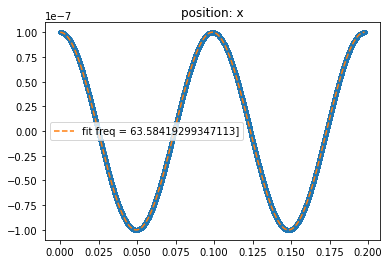

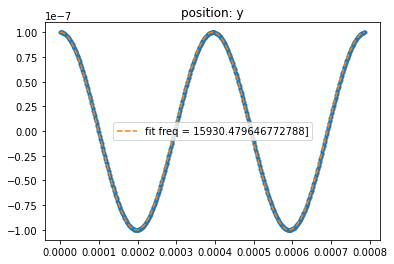

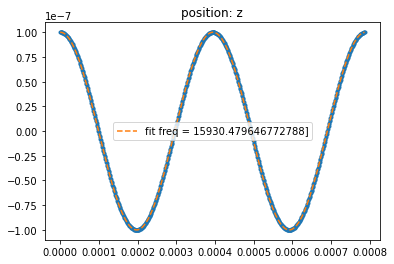

In [116]:
plot_trap_freq( 0, PosData)
plot_trap_freq( 1, PosData)
plot_trap_freq( 2, PosData)

In [109]:

E = []

for i in range( len( PosData ) ):
    E.append(get_TotalEnergy_PerRun(PosData[i], VelData[i]))
    
E_sqrd = []
for i in E:
    E_sqrd.append( [j**2 for j in i] )
    
E_avg = []    
for i in E_sqrd:
    E_avg.append( sum(i)/len(i) )
    
E_rms = []
for i in E_avg:
    E_rms.append( np.sqrt(i) )
    
plt.plot(time[:truncate], E_rms[:truncate])
plt.xlabel('time [s]')
plt.ylabel('Energy [ J ]')
plt.title('E_rms over time')
plt.show()

NameError: name 'VelData' is not defined

In [ ]:
file_num  = "00a"

fileVel   = "../data1/vel_distro"      + file_num + ".txt"
filePos   = "../data1/pos_distro"      + file_num + ".txt"
fileInt   = "../data1/intensity_data"  + file_num + ".txt"

PosData = h.get_particle_data( filePos )[2]
VelData = h.get_particle_data( fileVel )[2]

time = np.linspace(0, steps*dt, int(steps/period))
x  = reformat(PosData, 1)

fit = fit_sin(time, x)
fit_curve = fit["fitfunc"]
w   = fit["omega"]

print(w)

plt.plot( time[:truncate], x[:truncate] )
plt.plot( time[:truncate], fit_curve(time[:truncate]), '--' )
plt.show()

In [ ]:

E = []

for i in range( len( PosData ) ):
    E.append(get_TotalEnergy_PerRun(PosData[i], VelData[i]))
    
E_sqrd = []
for i in E:
    E_sqrd.append( [j**2 for j in i] )
    
E_avg = []    
for i in E_sqrd:
    E_avg.append( sum(i)/len(i) )
    
E_rms = []
for i in E_avg:
    E_rms.append( np.sqrt(i) )
    
fit = fit_sin(time, E_rms)
print(fit["omega"])
    
plt.plot(time[:truncate], E_rms[:truncate])
plt.xlabel('time [s]')
plt.ylabel('Energy [ J ]')
plt.title('E_rms over time')
plt.show()

In [ ]:
file_num  = "00a"

fileVel   = "../data1/vel_distro"      + file_num + ".txt"
filePos   = "../data1/pos_distro"      + file_num + ".txt"
fileInt   = "../data1/intensity_data"  + file_num + ".txt"

PosData = h.get_particle_data( filePos )[2]
VelData = h.get_particle_data( fileVel )[2]

time = np.linspace(0, steps*dt, int(steps/period))
x  = reformat(PosData, 2)

fit = fit_sin(time, x)
fit_curve = fit["fitfunc"]
w   = fit["omega"]

print(w)

plt.plot( time[:truncate], x[:truncate] )
plt.plot( time[:truncate], fit_curve(time[:truncate]), '--' )
plt.show()

In [ ]:

E = []

for i in range( len( PosData ) ):
    E.append(get_TotalEnergy_PerRun(PosData[i], VelData[i]))
    
E_sqrd = []
for i in E:
    E_sqrd.append( [j**2 for j in i] )
    
E_avg = []    
for i in E_sqrd:
    E_avg.append( sum(i)/len(i) )
    
E_rms = []
for i in E_avg:
    E_rms.append( np.sqrt(i) )
    
fit = fit_sin(time, E_rms)
print(fit["omega"])
    
plt.plot(time[:truncate], E_rms[:truncate])
plt.xlabel('time [s]')
plt.ylabel('Energy [ J ]')
plt.title('E_rms over time')
plt.show()